## 3 - Working with Points

In this notebook, we will show how GPlately's `Points` object:
- Reconstructs point data and their motion paths through geological time; and
- Calculates these points' velocity data 

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import cartopy.crs as ccrs
import matplotlib
from matplotlib import image

The `Points` object needs the `PlateReconstruction` object as a parameter.

We can create the `PlateReconstruction` object with a `rotation_model`, `topology_features` and some `static_polygons`, which we can get using GPlately's `DataServer` object. Let's get these files from Müller et al. 2019 and call the DataServer object `gdownload`. 

In [2]:
# Call GPlately's DataServer object and download the Muller et al. 2019 rotation_model, topology_features and
# static_polygons to cache
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

### Reconstructing seed point motion paths with the `Points` object

With GPlately, we can reconstruct features on topological plates as they move relative to other frames of reference through geological time. By plotting their positions at several timesteps, we can trace an "age track" of their motion.

Let's construct the age track of two points on the Hawaiian-Emperor Seamount Chain corresponding to the present-day:
- Meiji Seamount (lat: 53.5 N, lon: 164.45 E)
- Mauna Kea Volcano (lat: 19.8202 N, lon: -155.4696 W)

To track these points' motion, we need to assign them to a _moving_ topological plate and an _anchored_ topological plate, which is the frame of reference for the moving plate's motion. We can do this with a plate ID, which is a non-negative integer number. Since these points are on the Pacific Plate, we'll label the moving plate with the ID 901. We'll reconstruct this plate's motion with respect to the Earth's spin axis. Therefore, the anchored topological plate will be a stationary geological element, like a mantle plume, which has an ID of 0.

Let's trace the points' locations over 85 million years. 

In [3]:
# Longitude and latitude of the Hawaiian-Emperor Seamount chain seed points 
pt_lon = np.array([-155.4696, 164.3])
pt_lat = np.array([19.8202, 53.5])

# Call the Points object: pass the PlateReconstruction object, and the latitudes and longitudes of the seed points.
gpts = gplately.Points(model, pt_lon, pt_lat)

# Motion path variables
oldest_reconstruction_time = 85
anchor_plate_id = 0 # Anchored plate ID (a stationary mantle plume, absolute reference frame)
moving_plate = 901 # Moving plate ID, (Pacific Plate)

# Arrays to fill with reconstructed points
rlons = np.empty((oldest_reconstruction_time, pt_lon.size))
rlats = np.empty((oldest_reconstruction_time, pt_lat.size))

# Determine the seed point's position every millionth year from present day to 85 Ma
time_array = range(0, oldest_reconstruction_time)
for time in time_array:
    rlons[time], rlats[time] = gpts.reconstruct(time, anchor_plate_id)

### Visualising the reconstructed locations of point features using `PlotTopologies`
We can visualise the age tracks of a point feature on a map using GPlately's `PlotTopologies` object. To call it, we need to pass:

- the `PlateReconstruction` plate motion model we just created
- a specific reconstruction time (Ma),
- a coastline filename or `<pygplates.FeatureCollection>` object,
- a continent filename or `<pygplates.FeatureCollection>` object,
- and a continent-ocean boundary (COBs) filename or `<pygplates.FeatureCollection>` object,

Let's set `time = 0` so that we can visualise the motion of our point features on the present-day Earth. Let's use shapefiles of `coastlines`, `continents` and `COBs` from Müller et al. (2019). We can download them with GPlately's `DataServer` object. 

In [4]:
# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

#### Obtaining bathymetry rasters with `DataServer`
Let's download the ETOPO1 global relief model by the National Oceanic and Atmospheric Administration (NOAA) to plot some bathymetric data. We can download this raster in a TIF format using a new instance of `DataServer`, which we will call `"etopo_tif"`. It is returned as an ndarray that can be plotted using `imshow`.

In [5]:
# Obtain the ETOPO1 tif image from NOAA
etopo_tif_img = gdownload.get_raster("ETOPO1_tif")

Let's use `PlotTopologies` to map out this motion path!

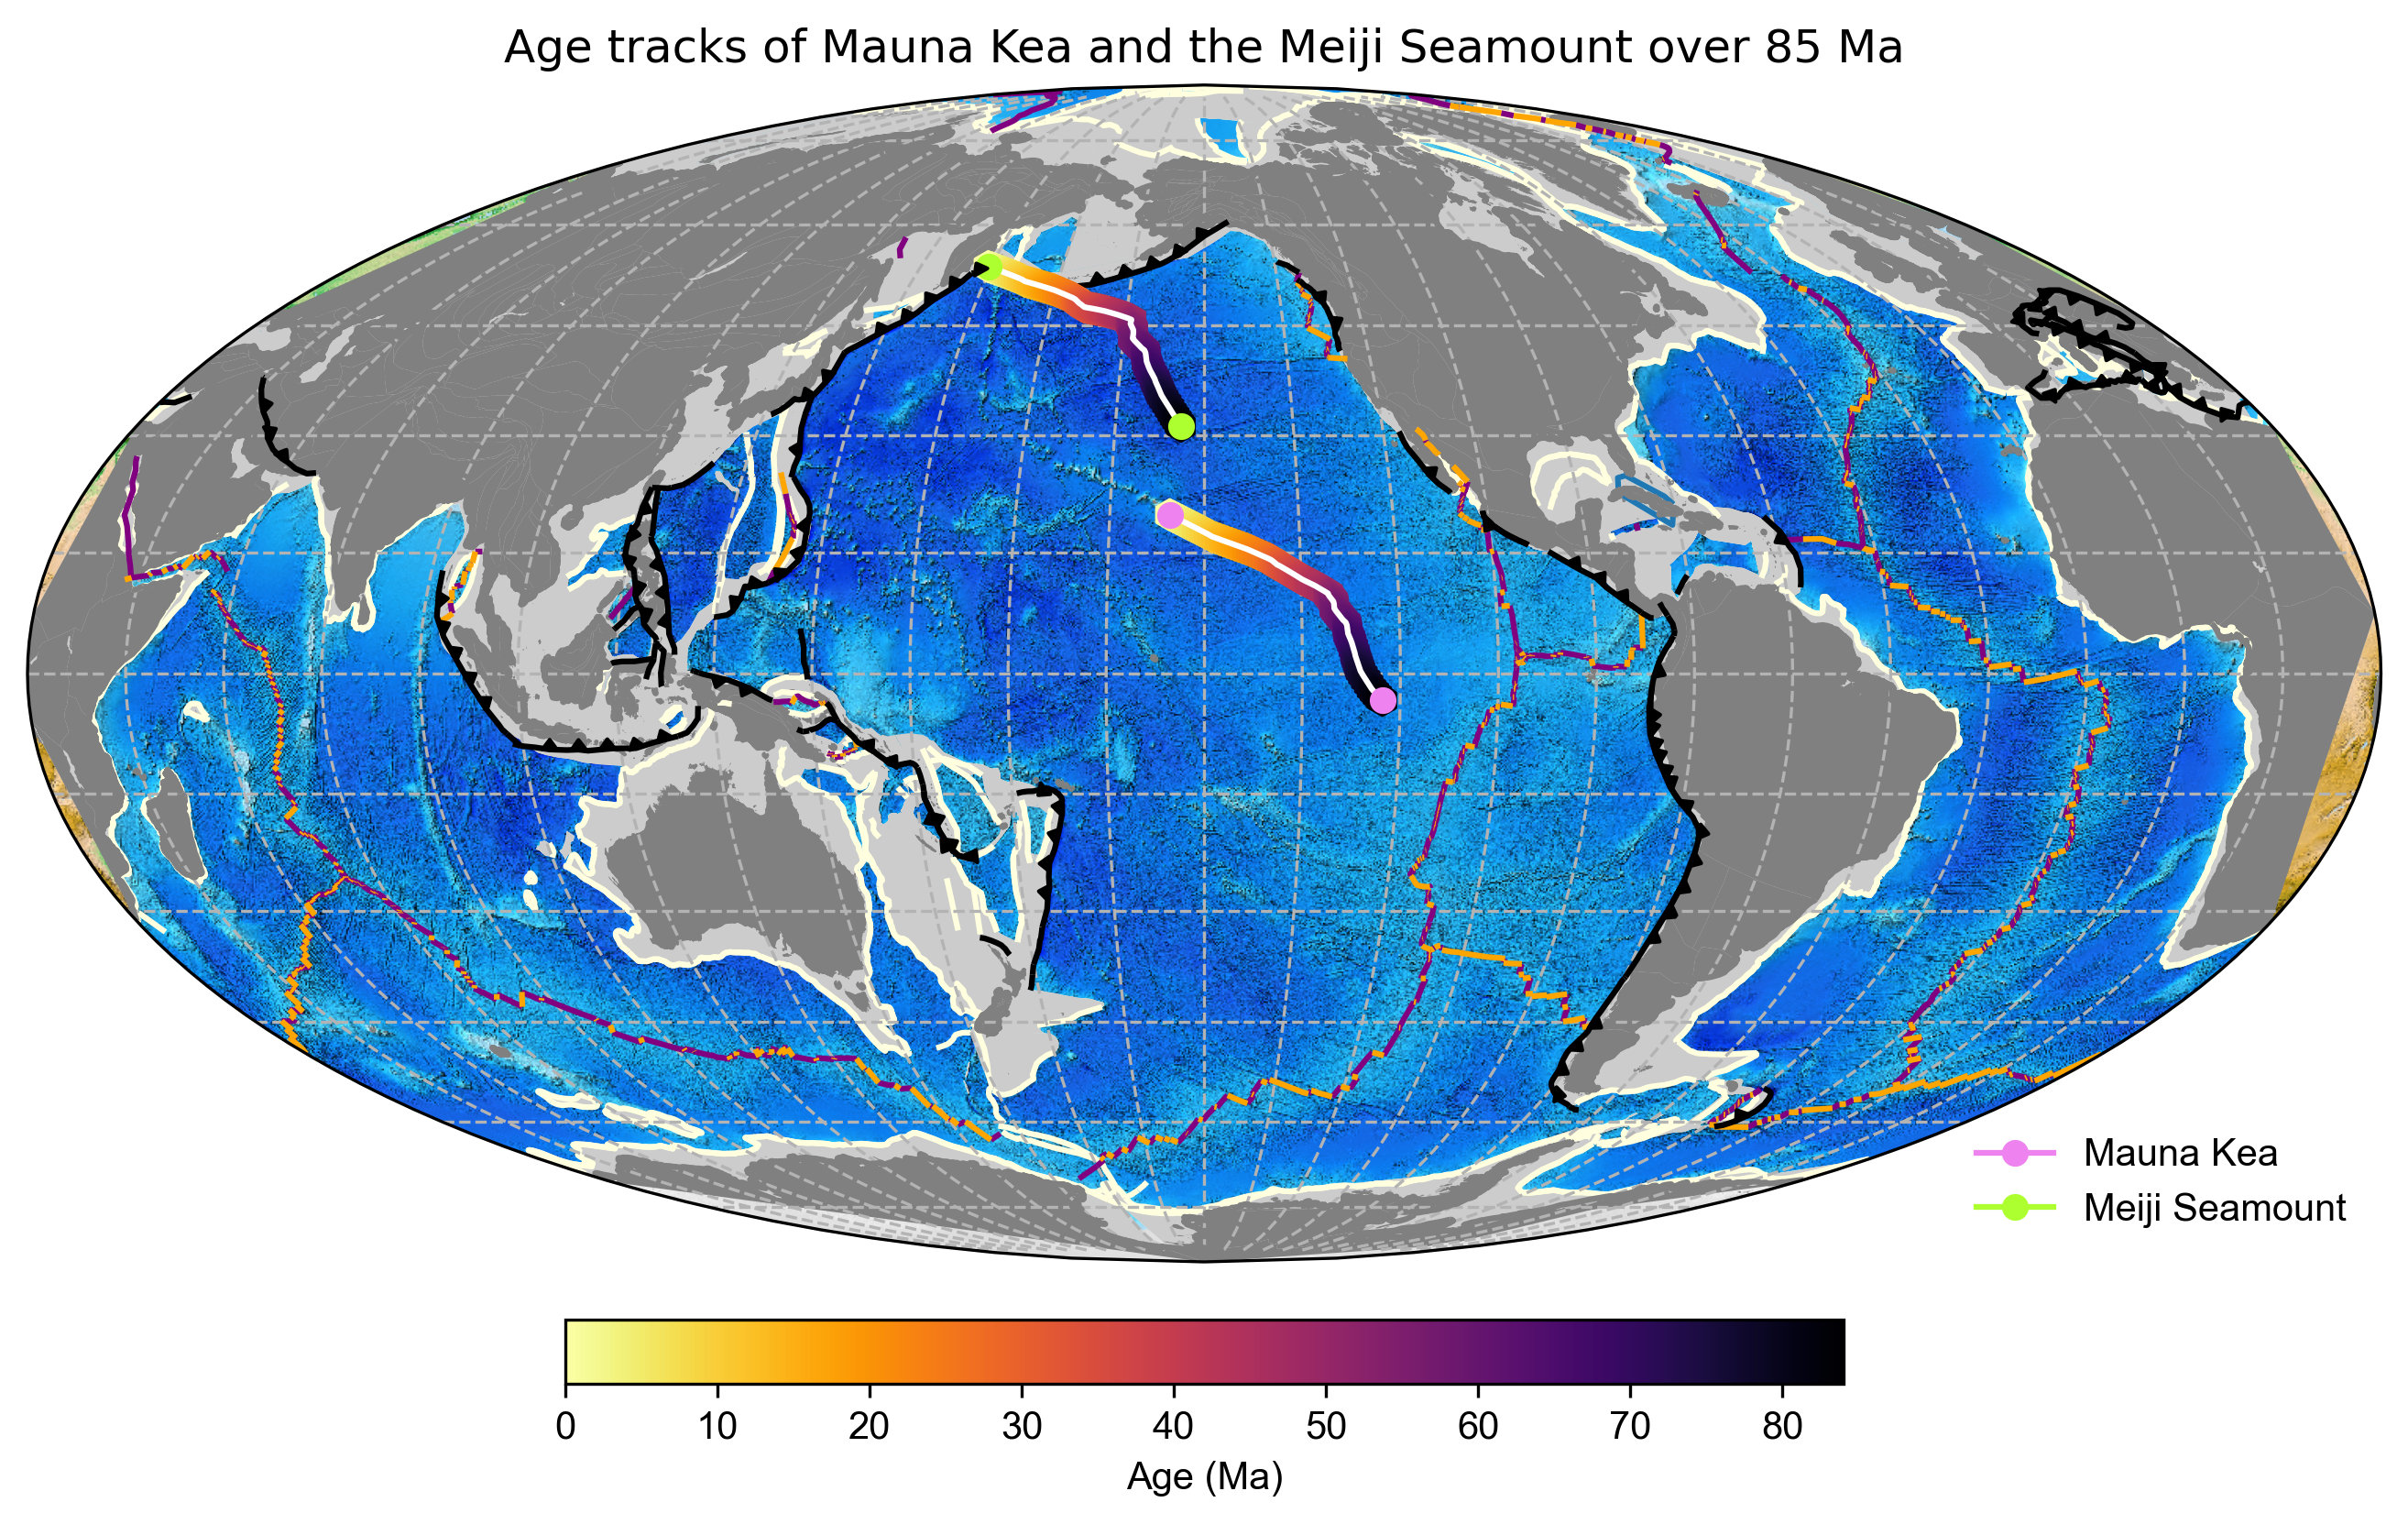

In [6]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(12,7), dpi=300)
ax2 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = -150))
ax2.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.rcParams['font.family'] = 'Arial'
plt.title("Age tracks of Mauna Kea and the Meiji Seamount over 85 Ma")

# Plot shapefile features, subduction zones and MOR boundaries at present day
gplot.time = 0 #Ma
ax2.imshow(etopo_tif_img, extent=[-180,180,-90,90], transform=ccrs.PlateCarree()) # Plot the bathymetric data
gplot.plot_continent_ocean_boundaries(ax2, color='lightyellow')
gplot.plot_continents(ax2, facecolor='0.8')
gplot.plot_coastlines(ax2, color='0.5')
gplot.plot_ridges(ax2, color='purple')
gplot.plot_transforms(ax2, color='orange')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k', zorder=3)

# Plot the seed points' locations every Ma through geological time
point_colors = ["violet", "greenyellow"]
labels = ["Mauna Kea", "Meiji Seamount"]
for i in range(0, len(pt_lon)):
    l1=ax2.scatter(rlons[:,i], rlats[:,i], 60, c=time_array, marker='h', cmap="inferno_r", 
                   transform=ccrs.PlateCarree(), zorder=2)
    ax2.plot(rlons[:,i], rlats[:,i], 'w', transform=ccrs.Geodetic())
    ax2.plot(rlons[0,i],rlats[0,i], color=point_colors[i], marker="o", transform=ccrs.PlateCarree(), label=labels[i])
    ax2.plot(rlons[-1,i],rlats[-1,i], color=point_colors[i], marker="o", transform=ccrs.PlateCarree())

# If you want to show the full globe, you must set global extent
ax2.set_global()
plt.legend(frameon=False, loc="lower right")

# Create a color bar
fig.colorbar(l1, ax=ax2, shrink=0.5, pad=0.04, orientation = "horizontal").set_label('Age (Ma)')

### Obtaining velocity data

The `plate_velocity` method on GPlately's `Points` object calculates the x and y Cartesian (north/east/down) components of a topological plate's velocity as the plate moves through geological time. The magnitude of its velocity is the hypotenuse of these components.

Let's calculate our seed points' velocities over time using `gpts` (the GPlately `Points` object).

In [7]:
# Arrays to fill with plate velocity data
vel_x = np.empty((oldest_reconstruction_time, pt_lon.size))
vel_y = np.empty((oldest_reconstruction_time, pt_lon.size))
vel_mag = np.empty((oldest_reconstruction_time, pt_lon.size))

# Obtain x and y components of north/east/down velocity at each Ma using the Points object
for time in time_array:
    vel_x[time], vel_y[time] = gpts.plate_velocity(time)
    
    # Magnitude at each Ma is the hypotenuse of the components
    vel_mag[time] = np.hypot(vel_x[time], vel_y[time])

Plotting the flowlines and velocity data side-by-side:

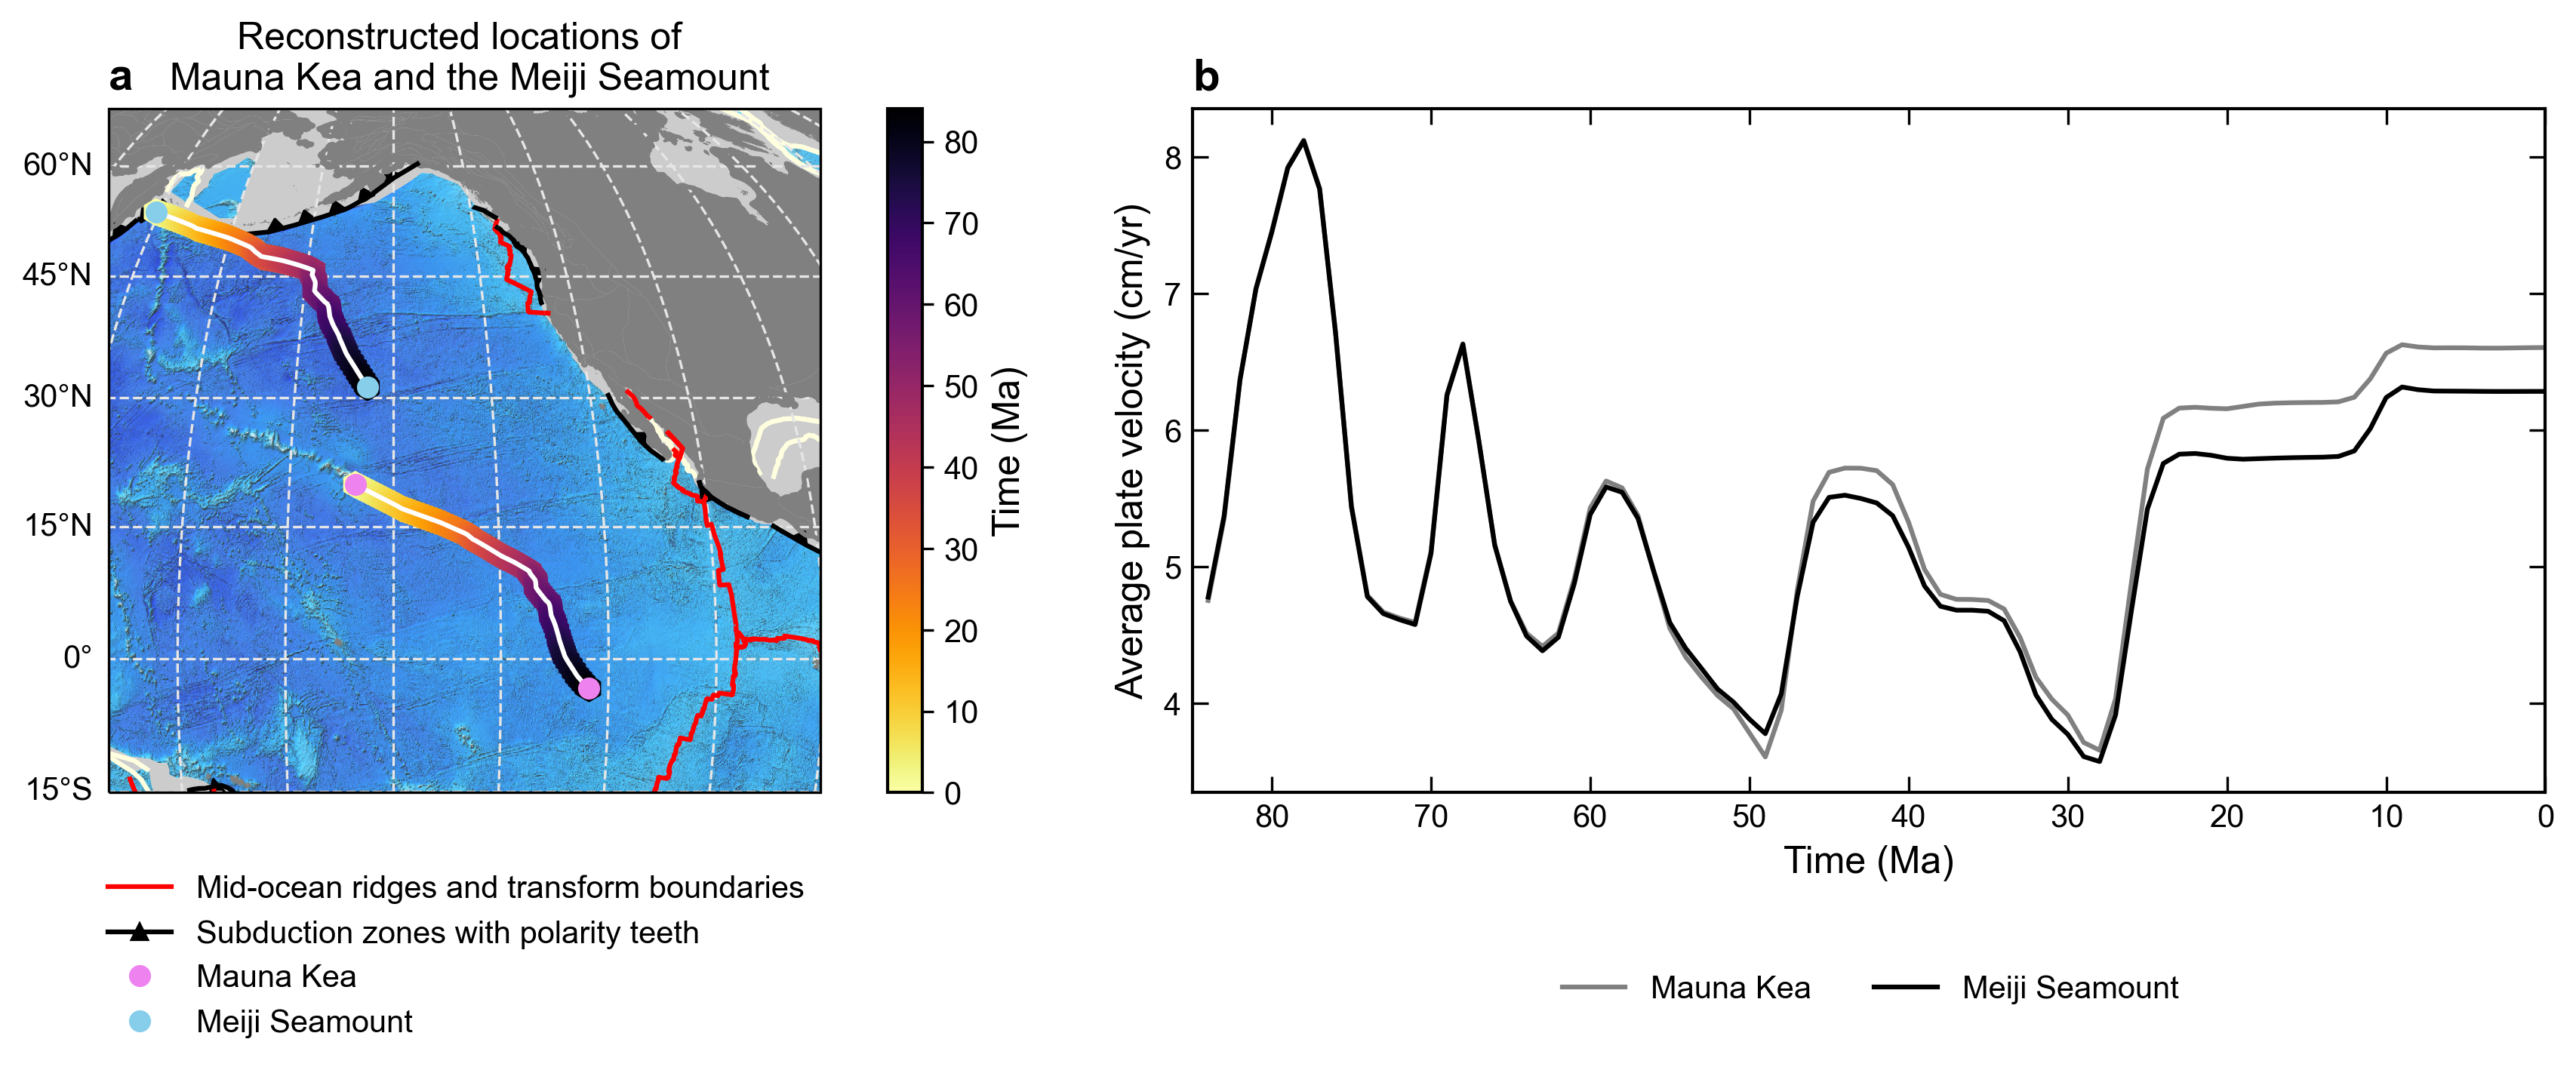

In [8]:
import matplotlib.patches as mpat
from matplotlib.lines import Line2D

# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,4), dpi=300)

# ----------------------------------------------- FIRST SUBPLOT -----------------------------------------------------
ax2 = fig.add_subplot(121, projection=ccrs.Mollweide(central_longitude = -150))
ax2.set_extent([-90, -190, -10, 60])
matplotlib.rcParams['axes.linewidth'] = 1
gl = ax2.gridlines(color='0.9',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15), draw_labels=True)
gl.inline_labels = False

plt.title("Reconstructed locations of \n Mauna Kea and the Meiji Seamount")
ax2.set_title("a", loc='left', fontsize="14", weight="demi")

# Plot shapefile features, subduction zones and MOR boundaries at present day
gplot.time = 0 #Ma
ax2.imshow(etopo_tif_img, extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),
          alpha=0.8) # Bathymetric data
gplot.plot_continent_ocean_boundaries(ax2, color='lightyellow')
gplot.plot_continents(ax2, facecolor='0.8')
gplot.plot_coastlines(ax2, color='0.5')
gplot.plot_ridges_and_transforms(ax2, color='red')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')

# Plot the seed points' locations every Ma through geological time
point_colors = ["violet", "skyblue"]
labels = ["Mauna Kea", "Meiji Seamount"]
for i in range(0, len(pt_lon)):
    l1=ax2.scatter(rlons[:,i], rlats[:,i], 60, c=time_array, marker='h', cmap="inferno_r", 
                   transform=ccrs.PlateCarree(), zorder=2)
    ax2.plot(rlons[:,i], rlats[:,i], 'w', transform=ccrs.Geodetic())
    ax2.plot(rlons[0,i],rlats[0,i], color=point_colors[i], marker="o", transform=ccrs.PlateCarree(), label=labels[i])
    ax2.plot(rlons[-1,i],rlats[-1,i], color=point_colors[i], marker="o", transform=ccrs.PlateCarree())

    
legend_elements = [Line2D([0], [0], linestyle='-', color='r', label="Mid-ocean ridges and transform boundaries"),
                   Line2D([0], [0], marker='^', linestyle='-', color='k', label='Subduction zones with polarity teeth',
                          markerfacecolor='k', markersize=5),
                   Line2D(range(1), range(1), marker='o', linestyle="", color='violet', label="Mauna Kea"),
                   Line2D(range(1), range(1), marker='o', linestyle="", color='skyblue', label="Meiji Seamount")
                  ]

# Create a color bar, legend
fig.colorbar(l1, ax=ax2, shrink=1).set_label('Time (Ma)', fontsize=12)
plt.legend(handles=legend_elements, loc = "lower left", bbox_to_anchor=(-0.04, -0.4), ncol = 1, frameon=False)


# --------------------------------------------- SECOND SUBPLOT -----------------------------------------------------
# Show plot of average plate velocity mag (cm/yr) at each millionth year b/w 0-150 Ma
p = fig.add_subplot(122)
p.tick_params(direction="in", length=5, top=True, right=True)

# Use a Gaussian filter to smoothen the velocity data, and plot it
from scipy.ndimage import gaussian_filter
vel_mag_smoothed = gaussian_filter(vel_mag, sigma=1)
colors = ["grey", "k"]
for i in range(0,len(pt_lon)):
    plt.plot(time_array, vel_mag_smoothed[:,i], color=colors[i], label=labels[i])
    
# Plot settings
plt.legend(labels, frameon=False, ncol=2, bbox_to_anchor=(0.75, -0.225))
plt.title("b", loc='left', fontsize="14", weight="demi")
# plt.title("Average velocity of Mauna Kea and the Meiji Seamount")
plt.xlabel('Time (Ma)', fontsize=12)
plt.ylabel('Average plate velocity (cm/yr)', fontsize=12)
plt.xlim([0, oldest_reconstruction_time])
plt.gca().invert_xaxis()
# plt.grid(alpha=0.3)
plt.subplots_adjust(wspace=.075) # spacing between subplots

plt.show()